In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys

!git clone -b recovery2  https://github.com/wjteng/LBC-IoT-Key-Recovery.git

sys.path.insert(0,'/content/LBC-IoT-Key-Recovery')

import numpy as np
from os import urandom
import lbciot as cipher
import pandas as pd
import train_nets as tn

rounds = 5;
epoch = 40;
diff1 = 0x0020;
diff2 = 0x0000;

name = str(diff1)+"_"+str(diff2)+"_r="+str(rounds)+"_epoch="+str(epoch);

model, h =tn.train_distinguisher(epoch,(diff1,diff2),num_rounds=rounds,depth=10);

model.save('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name);

Mounted at /content/gdrive/
Cloning into 'LBC-IoT-Key-Recovery'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 115 (delta 61), reused 91 (delta 46), pack-reused 0
Receiving objects: 100% (115/115), 256.36 KiB | 18.31 MiB/s, done.
Resolving deltas: 100% (61/61), done.
Epoch 1/40
200/200 [==============================] - 38s 111ms/step - loss: 0.2182 - acc: 0.6417 - val_loss: 0.2461 - val_acc: 0.6265 - lr: 0.0020
Epoch 2/40
200/200 [==============================] - 22s 109ms/step - loss: 0.0951 - acc: 0.8878 - val_loss: 0.1011 - val_acc: 0.8755 - lr: 0.0018
Epoch 3/40
200/200 [==============================] - 22s 108ms/step - loss: 0.0470 - acc: 0.9558 - val_loss: 0.0490 - val_acc: 0.9524 - lr: 0.0016
Epoch 4/40
200/200 [==============================] - 22s 108ms/step - loss: 0.0380 - acc: 0.9665 - val_loss: 0.0372 - val_acc: 0.9672 - lr: 0.0014
Epoch 5/40
200/200 [=============

Mounted at /content/gdrive/
Cloning into 'LBC-IoT-Key-Recovery'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 118 (delta 63), reused 91 (delta 46), pack-reused 0
Receiving objects: 100% (118/118), 258.60 KiB | 12.93 MiB/s, done.
Resolving deltas: 100% (63/63), done.
0
10000
20000
30000
40000
50000
60000


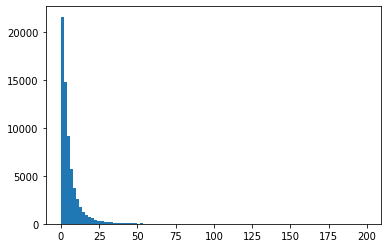

found max:36033
correct key:36033
[[36033   199]
 [ 3265   173]
 [44225   156]
 [35969   150]
 [ 3137   140]
 [ 3201   137]
 [35905   137]
 [44161   133]
 [11457   132]
 [35009   131]
 [11393   119]
 [11329   110]
 [35841   109]
 [ 3073   108]
 [36065   108]
 [44097   108]
 [36037   107]
 [ 2241   104]
 [36035   104]
 [33985   103]
 [11265   101]
 [33921   101]
 [44033   101]
 [51393   101]
 [43201   100]
 [42177    99]
 [ 3297    96]
 [42113    96]
 [36049    94]
 [ 1217    92]]
found max:3267
correct key:36033
[[ 3267    91]
 [ 1153    90]
 [34945    90]
 [ 2113    89]
 [ 3269    89]
 [ 3281    89]
 [36051    89]
 [ 9409    88]
 [ 3139    87]
 [ 9345    86]]


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys

!git clone -b recovery2  https://github.com/wjteng/LBC-IoT-Key-Recovery.git

sys.path.insert(0,'/content/LBC-IoT-Key-Recovery')

import numpy as np
from os import urandom
import lbciot as cipher
import pandas as pd
import train_nets as tn

n = 200; #number of plaintext pairs

rounds = 5;
epoch = 40;
diff1 = 0x0020;
diff2 = 0x0000;

key = np.frombuffer(urandom(10),dtype=np.uint16).reshape(5,-1);
keys = np.frombuffer(urandom(10*n),dtype=np.uint16).reshape(5,-1)*0+1 ;


for i in range(0,n):
  for j in range(0,5):
    keys[j][i]=key[j];


pt0l = np.frombuffer(urandom(2*n),dtype=np.uint16);
pt0r = np.frombuffer(urandom(2*n),dtype=np.uint16);

p0l = np.copy(pt0l); 
p0r = np.copy(pt0r);

p1l = p0l^diff1;
p1r = p0r^diff2;

ks = cipher.expand_key(keys, rounds + 1);

c0l,c0r = cipher.encrypt((p0l,p0r),ks);
c1l,c1r = cipher.encrypt((p1l,p1r),ks);



from tensorflow import keras

name = str(diff1)+"_"+str(diff2)+"_r="+str(rounds)+"_epoch="+str(epoch);
model = keras.models.load_model('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name);

allkeys = ks[rounds]*0;

count = np.zeros(2**16,dtype=int);

for i in range(0,2**16):
  if i%10000==0:
    print(i);
  c0l_dec1,c0r_dec1 = cipher.dec_one_round((c0l,c0r),allkeys);
  c1l_dec1,c1r_dec1 = cipher.dec_one_round((c1l,c1r),allkeys);
  X = cipher.convert_to_binary([c0l_dec1,c0r_dec1,c1l_dec1,c1r_dec1]);
  Z = model.predict(X,batch_size=10000);
  count[allkeys[0]] =  np.sum(Z>0.5);
  allkeys = allkeys + 1;

df = pd.DataFrame(count);
df.to_csv('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+'count_'+str(diff1)+'_'+str(diff2)+'.csv');

import matplotlib.pyplot as plt

plt.hist(count, bins=100)
plt.savefig('/content/gdrive/MyDrive/LBC-IoT-Key-Recovery/'+name+'_counthist.png')
plt.show()


count[np.argmax(count)]
print('found max:'+str(np.argmax(count)))
print('correct key:'+str(ks[rounds][0]));
count[41855]
sorted_count = -np.sort(-count);
temp = count;
top = 30;
rank = np.zeros((top,2),dtype=int);
for i in range(0,top):
  max_index = np.argmax(temp);
  rank[i][0] = max_index;
  rank[i][1] = temp[max_index];
  temp[max_index]=-1;

print(rank);

 

